In [1]:
from numba import cuda, jit, njit, vectorize, guvectorize, prange, float64
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.signal as signal

# load some data

In [2]:
data = loadmat('./data/sim_single_cyst.mat')
# print(data.keys())

fs = np.squeeze(data['fs']) # sampling frequency
fs = np.float64(fs)
c = np.squeeze(data['c']) # speed of sound
# when c is uint16 it raises error, thus it should be casted into proper type
c = np.float64(c)

pitch = np.squeeze(data['pitch']) # pitch
angles = np.squeeze(data['angles']) # transmit angles

rf = np.squeeze(data['rf']) # radio-frequency (rf) data acquired by probe elements
rf = np.transpose(rf,(2,1,0)) # transposition to (n_transmissions, n_channels, n_samples) order

# decimation - the fs=1e8 is not necessary high
dec = 4
rf = signal.decimate(rf, dec)
fs = fs/dec

print(f'Data loaded. Sampling frequency [MHz]: {fs*1e-6}')



Data loaded. Sampling frequency [MHz]: 25.0


***
# FIR filter
***
<font size="4">
The finite impulse response (FIR) filter is given by equation \eqref{fir}

\begin{equation}
    y[n] = \sum_{k=0}^{N-1} h[k]x[n-k] 
    \label{fir} \tag{1}
\end{equation}

where *x* is an input signal, *h* is the impulse response of the filter and *y* is an output signal.
Filtration is realised by convolving the signal with impulse response of the filter.

  
    
***    
</font>

# FIR filter implementation

### define functions

In [3]:
def present_signal(sig, fs, color='b', title=''):
    '''
    The function display input signal and its spectrum.
    '''
    f, p = signal.periodogram(sig,fs=fs)
    
    fig,ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title)
    ax[0].plot(sig,color=color)
    ax[0].set_title('signal')
    ax[0].set_xlabel('samples')
    ax[0].set_ylabel('amplitude [a.u.]')
    
    ax[1].semilogy(f*1e-6, p/np.max(p),color=color)
    ax[1].set_title('power spectrum')
    ax[1].set_xlabel('frequency [MHz]')
    ax[1].set_ylabel('amplitude [a.u.]')
    
    plt.tight_layout()


def dotproduct(a, b):
    '''
    Function enumerate dot product of two vectors.
    '''
    c = 0
    for i in range(a.size):
        c += a[i]*b[i]
    return c

# jit version of dotproduct()
dotproduct_jit = njit()(dotproduct)

# device function version of dotproduct()
dotproduct_gpu = cuda.jit(device=True)(dotproduct)

              
def convolve_np(sig, h):
    '''
    The function convolve vectors (signals - sig) with vector (filter impulse response - h).
    Convolve is along the last dimension of the first array. 
    This function use numpy.sum() and broadcasting.
    '''
    
    sigflt = np.zeros(sig.shape)
    for i in range(sigflt.shape[-1] - h.shape[-1]):
        sigflt[..., i] = np.sum(sig[...,i:i+h.shape[-1]] * h[::-1])
        
    return sigflt


def convolve(sig, h):
    '''
    The function convolve vectors (signals - sig) with vector (filter impulse response - h).
    Convolve is along the last dimension of the first array. 
    '''
    
    sigflt = np.zeros(sig.shape)
    for i0 in range(sigflt.shape[0]):
        for i1 in range(sigflt.shape[1]):
            for i2 in range(sigflt.shape[2] - h.shape[-1]):
                sigflt[i0, i1, i2] = dotproduct(sig[i0, i1, i2:i2+h.shape[-1]], h[::-1])
        
    return sigflt



# The function called by function with @jit decorator should 
# be @jit decorated aswell. Thus, the dotproduct_jit() version is used here, 
# insead of dotproduct().
@njit
def convolve_jit(sig, h):
    '''
    The function convolve vectors (signals - sig) with vector (filter impulse response - h).
    Convolve is along the last dimension of the first array. 
    This is jit version of convolve(). 
    '''
    
    sigflt = np.zeros(sig.shape)
    for i0 in range(sigflt.shape[0]):
        for i1 in range(sigflt.shape[1]):
            for i2 in range(sigflt.shape[2]-h.shape[-1]):
                sigflt[i0,i1,i2] = dotproduct_jit(sig[i0,i1,i2:i2 + h.shape[-1]], h[::-1])
        
    return sigflt


# kernel    
@cuda.jit
def convolve_kernel(sigflt, sig, h):
    """
    Kernel function.
    The function convolve vectors (signals - sig) with vector (filter impulse response - h).
    Kernel function does not return a value - it modifies one of arguments into result (here, sigflt).
    
    sigflt - output filtered 3D array,
    sig - input 3D array,
    h - filter impulse response.
    """
    
    i, j, k = cuda.grid(3)
    if i >= sig.shape[0] or j >= sig.shape[1] or k >= sig.shape[2] - h.shape[-1]:
        return
    
    # kernel does not return a value - it modifies one of arguments into result
    sigflt[i,j,k] = dotproduct_gpu(sig[i,j,k:k + h.shape[-1]], h)

    

def fir_gpu(rf, h):
    '''
    Wrapper funciton for calling gpu kernel.
    
    rf - input array,
    h - filter impulse response.
    '''
    
    # allocate output array on the device
    n0, n1, n2 = rf.shape

    
    # put data arrays to the device
    rfflt = cuda.device_array((n0, n1, n2))
    
    rf = np.ascontiguousarray(rf)
    rf = cuda.to_device(rf)
    
    h = np.ascontiguousarray(h)
    h = cuda.to_device(h)
    
    # define thread per block and blocks per grid size
    # Note: total number of threads in block should not be bigger than 1024/512 (hardware dependent)
    blockshape = (8, 8, 8)
    gridshape_0 = (n0 + blockshape[0] - 1) // blockshape[0]
    gridshape_1 = (n1 + blockshape[1] - 1) // blockshape[1]
    gridshape_2 = (n2 + blockshape[2] - 1) // blockshape[2]
    gridshape = (gridshape_0, gridshape_1, gridshape_2)
    
    # run kernel
#     with cuda.defer_cleanup():
    convolve_kernel[gridshape,blockshape](rfflt, rf, h[::-1])
    
    # transfer data from device to host
    rfflt = rfflt.copy_to_host()
    return rfflt    
    

### Tests

Time test: convolve, direct implementation:
CPU times: user 2min 8s, sys: 9.38 ms, total: 2min 8s
Wall time: 2min 8s
-----------------------------------------------------
Time test: convolve with numpy.sum() :
CPU times: user 1.2 s, sys: 7.94 ms, total: 1.21 s
Wall time: 1.21 s
-----------------------------------------------------
Time test: simple convolve compiled using jit:
CPU times: user 442 ms, sys: 4.02 ms, total: 446 ms
Wall time: 445 ms
-----------------------------------------------------
Time test: simple convolve calculated using gpu:
CPU times: user 27.9 ms, sys: 16.1 ms, total: 43.9 ms
Wall time: 43.5 ms
-----------------------------------------------------


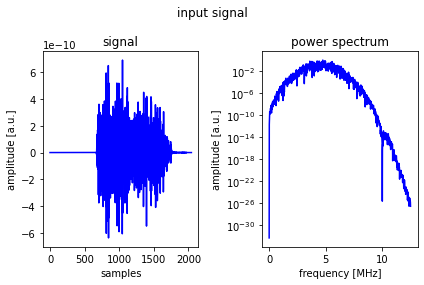

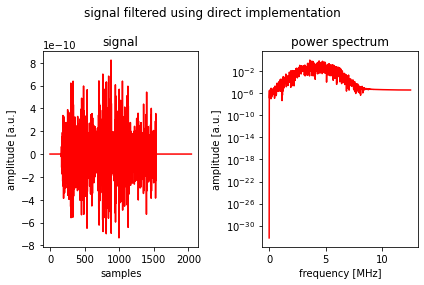

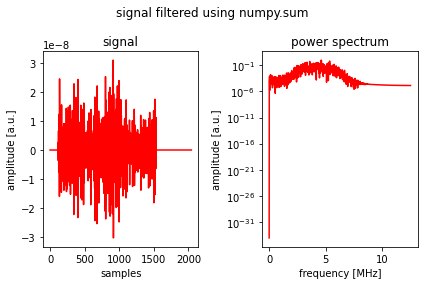

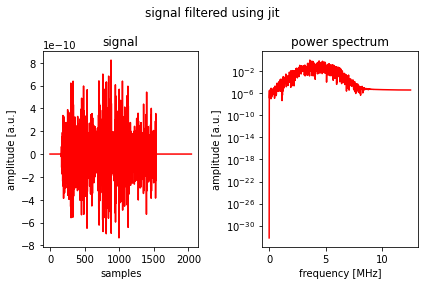

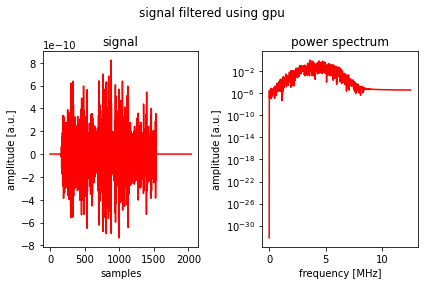

In [4]:
# get some signal from rf array
sig = rf[0,0,:]

# create filter impulse response (filter coefficient array)
ntaps = 512
# h = np.concatenate((np.linspace(0, 1, ntaps//2),
#                     np.linspace(1, 0, ntaps//2)))
h = np.ones(ntaps)


print('Time test: convolve, direct implementation:')
%time rfflt_dir = convolve(rf, h)
print('-----------------------------------------------------')

print('Time test: convolve with numpy.sum() :')
%time rfflt_np = convolve_np(rf, h)
print('-----------------------------------------------------')


# convolve compiled by jit (the time gain will be visible after second run)
# first run
rfflt_jit = convolve_jit(rf, h) 
# second run
print('Time test: simple convolve compiled using jit:')
%time rfflt_jit = convolve_jit(rf, h)
print('-----------------------------------------------------')

# first run
rfflt_gpu = fir_gpu(rf, h)
# second run
print('Time test: simple convolve calculated using gpu:')
%time rfflt_gpu = fir_gpu(rf, h)
print('-----------------------------------------------------')

# get some signals for graphs
sig = rf[0, 0, :]
sigflt_dir = rfflt_dir[0, 0, :]
sigflt_np = rfflt_np[0, 0, :]
sigflt_jit = rfflt_jit[0, 0, :]
sigflt_gpu = rfflt_gpu[0, 0, :]

# do some graphs
present_signal(sig, fs, 'blue', 'input signal')
present_signal(sigflt_dir, fs, 'red', 'signal filtered using direct implementation')
present_signal(sigflt_np, fs, 'red', 'signal filtered using numpy.sum')
present_signal(sigflt_jit, fs, 'red', 'signal filtered using jit')
present_signal(sigflt_gpu, fs, 'red', 'signal filtered using gpu')


In [5]:
! nvprof

======== Error: no application specified.


In [6]:
%%writefile /tmp/profiled_test.py

import numba
from numba import cuda
import numpy as np
import math

data = np.arange(1024, dtype=np.float32)
gpu_data = cuda.to_device(data)

@cuda.jit
def increment_by_one(an_array):
    pos = cuda.grid(1)
    if pos < an_array.size:
        an_array[pos] += 1
        
threadsperblock = (16,)
blockspergrid_x = math.ceil(data.shape[0] / threadsperblock[0])
blockspergrid = (blockspergrid_x, )

# numba.cuda.profile_stop()
increment_by_one[blockspergrid, threadsperblock](gpu_data)

Overwriting /tmp/profiled_test.py


In [7]:
! nvprof python /tmp/profiled_test.py

==22619== NVPROF is profiling process 22619, command: python /tmp/profiled_test.py
==22619== Profiling application: python /tmp/profiled_test.py
==22619== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   56.25%  2.3040us         1  2.3040us  2.3040us  2.3040us  cudapy::__main__::increment_by_one$241(Array<float, int=1, C, mutable, aligned>)
                   43.75%  1.7920us         1  1.7920us  1.7920us  1.7920us  [CUDA memcpy HtoD]
      API calls:   96.50%  114.52ms         1  114.52ms  114.52ms  114.52ms  cuDevicePrimaryCtxRetain
                    1.45%  1.7225ms         4  430.63us  419.28us  461.72us  cuDeviceTotalMem
                    1.22%  1.4519ms       404  3.5930us     121ns  164.48us  cuDeviceGetAttribute
                    0.26%  306.84us         8  38.355us  31.887us  61.828us  cuDeviceGetName
                    0.15%  183.66us         1  183.66us  183.66us  183.66us  cuModuleLoadDataEx
        

(5, 128, 2045)
